In [1]:
import gc
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date, timedelta
import keras
import time
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
import psycopg2
from sshtunnel import SSHTunnelForwarder

/home/lordafzal/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/lordafzal/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
neurons = 512                 
activation_function = 'tanh'  
loss = 'mse'                  
optimizer="adam"              
dropout = 0.25                 
batch_size = 12               
# epochs = 53  
epochs = 20
window_len = 7               
training_size = 0.8
merge_date = '2016-01-01'

In [6]:
def shrinkData(df):
    df_int = df.select_dtypes(include=['int'])
    df_int = df_int.apply(pd.to_numeric,downcast='unsigned')
    df_float = df.select_dtypes(include=['float'])
    df_float = df_float.apply(pd.to_numeric,downcast='float')
    df['date'] = pd.to_datetime(df['date'])
    cols = df.columns[df.dtypes.eq(object)]
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=0)
    return df

def query_to_DataFrame(sqlString):
    with SSHTunnelForwarder(
        ('24.228.50.99', 443),
        #ssh_private_key="</path/to/private/ssh/key>",
        ### in my case, I used a password instead of a private key
        ssh_username="root",
        ssh_password="b3110cFr13nd", 
        remote_bind_address=('localhost', 5432)) as server:

        server.start()
        print("server connected")

        params = {
         'database': 'Prices',
         'user': 'analyst',
         'password': 'st4rg4z3r',
         'host': 'localhost',
         'port': server.local_bind_port
         }

        conn = psycopg2.connect(**params)
        curs = conn.cursor()
        print("database connected")
        # Get a database cursor
        cur = conn.cursor()

        # Execute SQL
        cur.execute(sqlString)
    #     colnames = [desc.name for desc in curs.description] 
#         print("description is :", cur.description)
        # Get the result
        result = cur.fetchall()
        colnames = [desc[0] for desc in cur.description]
        frame = shrinkData(pd.DataFrame(result, columns=colnames))
    #     print(result)

        # Close connections
        conn.close()

        # Stop the tunnel
        server.stop()
        return frame


In [7]:
dji_data = query_to_DataFrame('SELECT * FROM Prices.dji')
dji_data.rename(columns={'date':'Date','dji_open': 'DJI_Open', 'dji_high':'DJI_High', 'dji_low':'DJI_Low', 'dji_close':'DJI_Close', 'dji_adjclose':'DJI_AdjClose', 'dji_volume':'DJI_Volume' }, inplace=True)
dji_data.head()

server connected
database connected


Date     DJI_Open     DJI_High      DJI_Low    DJI_Close  \
0 2016-01-04  2038.199951  2038.199951  1989.680054  2012.660034   
1 2016-01-05  2013.780029  2021.939941  2004.170044  2016.709961   
2 2016-01-06  2011.709961  2011.709961  1979.050049  1990.260010   
3 2016-01-07  1985.319946  1985.319946  1938.829956  1943.089966   
4 2016-01-08  1945.969971  1960.400024  1918.459961  1922.030029   

   DJI_AdjClose    DJI_Volume  
0   2012.660034  4.304880e+09  
1   2016.709961  3.706620e+09  
2   1990.260010  4.336660e+09  
3   1943.089966  5.076590e+09  
4   1922.030029  4.664940e+09

In [8]:
nya_data = query_to_DataFrame('SELECT * FROM Prices.nya')
nya_data.rename(columns={'date':'Date','nya_open': 'NYA_Open', 'nya_high':'NYA_High', 'nya_low':'NYA_Low', 'nya_close':'NYA_Close', 'nya_adjclose':'NYA_AdjClose', 'nya_volume':'NYA_Volume' }, inplace=True)
nya_data.head()

server connected
database connected


Date     NYA_Open     NYA_High      NYA_Low    NYA_Close  \
0 2016-01-04  2038.199951  2038.199951  1989.680054  2012.660034   
1 2016-01-05  2013.780029  2021.939941  2004.170044  2016.709961   
2 2016-01-06  2011.709961  2011.709961  1979.050049  1990.260010   
3 2016-01-07  1985.319946  1985.319946  1938.829956  1943.089966   
4 2016-01-08  1945.969971  1960.400024  1918.459961  1922.030029   

   NYA_AdjClose    NYA_Volume  
0   2012.660034  4.304880e+09  
1   2016.709961  3.706620e+09  
2   1990.260010  4.336660e+09  
3   1943.089966  5.076590e+09  
4   1922.030029  4.664940e+09

In [9]:
def merge_data(a, b, from_date=merge_date):
    """
    a: first DataFrame
    b: second DataFrame
    from_date: includes the data from the provided date and drops the any data before that date.
    returns merged data as Pandas DataFrame
    """
    merged_data = pd.merge(a, b, on=['Date'])
    merged_data = merged_data[merged_data['Date'] >= from_date]
    print("MergeHaymer")
    return merged_data


def add_volatility(data, coins=['BTC', 'DJI']):
    """
    data: input data, pandas DataFrame
    coins: default is for 'btc and 'eth'. It could be changed as needed
    This function calculates the volatility and close_off_high of each given coin in 24 hours, 
    and adds the result as new columns to the DataFrame.
    Return: DataFrame with added columns
    """
    for coin in coins:
    # calculate the daily change
        kwargs = {coin + '_change': lambda x: (x[coin + '_Close'] - x[coin + '_Open']) / x[coin + '_Open'],
                 coin + '_close_off_high': lambda x: 2*(x[coin + '_High'] - x[coin + '_Close']) / (x[coin + '_High'] - x[coin + '_Low']) - 1,
                 coin + '_volatility': lambda x: (x[coin + '_High'] - x[coin + '_Low']) / (x[coin + '_Open'])}
        data = data.assign(**kwargs)
    return data


def create_model_data(data):
    """
    data: pandas DataFrame
    This function drops unnecessary columns and reverses the order of DataFrame based on decending dates.
    Return: pandas DataFrame
    """
    #data = data[['Date']+[coin+metric for coin in ['btc_', 'eth_'] for metric in ['Close','Volume','close_off_high','volatility']]]
    data = data[['Date']+[coin+metric for coin in ['DJI_', 'NYA_'] for metric in ['Close','Volume']]]
    data = data.sort_values(by='Date')
    return data


def split_data(data, training_size=0.8):
    """
    data: Pandas Dataframe
    training_size: proportion of the data to be used for training
    This function splits the data into training_set and test_set based on the given training_size
    Return: train_set and test_set as pandas DataFrame
    """
    return data[:int(training_size*len(data))], data[int(training_size*len(data)):]


def create_inputs(data, coins=['BTC', 'DJI'], window_len=window_len):
    """
    data: pandas DataFrame, this could be either training_set or test_set
    coins: coin datas which will be used as the input. Default is 'btc', 'eth'
    window_len: is an intiger to be used as the look back window for creating a single input sample.
    This function will create input array X from the given dataset and will normalize 'Close' and 'Volume' between 0 and 1
    Return: X, the input for our model as a python list which later needs to be converted to numpy array.
    """
    norm_cols = [coin + metric for coin in coins for metric in ['_Close', '_Volume']]
    inputs = []
    print("window is ", window_len)
    print(" length of data is ", len(data))
    for i in range(len(data) - window_len):
        temp_set = data[i:(i + window_len)].copy()
        inputs.append(temp_set)
    for col in norm_cols:
        inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
    return inputs


def create_outputs(data, coin, window_len=window_len):
    """
    data: pandas DataFrame, this could be either training_set or test_set
    coin: the target coin in which we need to create the output labels for
    window_len: is an intiger to be used as the look back window for creating a single input sample.
    This function will create the labels array for our training and validation and normalize it between 0 and 1
    Return: Normalized numpy array for 'Close' prices of the given coin
    """
    return (data[coin + '_Close'][window_len:].values / data[coin + '_Close'][:-window_len].values) - 1


def to_array(data):
    """
    data: DataFrame
    This function will convert list of inputs to a numpy array
    Return: numpy array
    """
    x = [np.array(data[i]) for i in range (len(data))]
    return np.array(x)

In [10]:
def show_plot(data, tag):
    fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
    ax1.set_ylabel('Closing Price ($)',fontsize=12)
    ax2.set_ylabel('Volume ($ bn)',fontsize=12)
    ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
    ax2.set_yticklabels(range(10))
    ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
    ax1.set_xticklabels('')
    ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
    ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
    ax1.plot(data['Date'].astype(datetime.datetime),data[tag +'_High'])
    ax2.bar(data['Date'].astype(datetime.datetime).values, data[tag +'_Close'].values)
    fig.tight_layout()
    plt.show()
    
    
def date_labels():
    last_date = dji_data.iloc[0, 0]
    date_list = [last_date - datetime.timedelta(days=x) for x in range(len(X_test))]
    return[date.strftime('%m/%d/%Y') for date in date_list][::-1]


def plot_results(history, model, Y_target, coin):
    plt.figure(figsize=(25, 20))
    plt.subplot(311)
    plt.plot(history.epoch, history.history['loss'], )
    plt.plot(history.epoch, history.history['val_loss'])
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title(coin + ' Model Loss')
    plt.legend(['Training', 'Test'])

    plt.subplot(312)
    plt.plot(Y_target)
    plt.plot(model.predict(X_train))
    plt.xlabel('Dates')
    plt.ylabel('Price')
    plt.title(coin + ' Single Point Price Prediction on Training Set')
    plt.legend(['Actual','Predicted'])

    ax1 = plt.subplot(313)
    plt.plot(test_set[coin + '_Close'][window_len:].values.tolist())
    plt.plot(((np.transpose(model.predict(X_test)) + 1) * test_set[coin + '_Close'].values[:-window_len])[0])
    plt.xlabel('Dates')
    plt.ylabel('Price')
    plt.title(coin + ' Single Point Price Prediction on Test Set')
    plt.legend(['Actual','Predicted'])

    date_list = date_labels()
    ax1.set_xticks([x for x in range(len(date_list))])
    for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
        label.set_visible(False)

    plt.show()

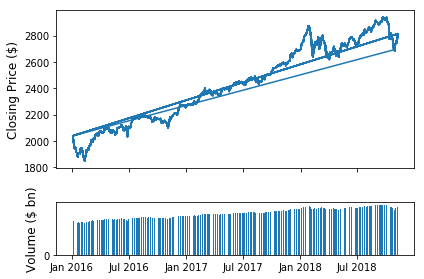

In [11]:
show_plot(dji_data, 'DJI')

In [8]:
plot_results(dji_history, dji_model, Y_test_btc, 'DJI')

NameError: name 'dji_history' is not defined

In [12]:
data = merge_data(dji_data, nya_data)

MergeHaymer


In [13]:
data = add_volatility(data, coins=['DJI', 'NYA'])

In [14]:
data = create_model_data(data)

In [15]:
data = data.drop_duplicates().reset_index(drop=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
# data = scaler.fit_transform(data)

In [ ]:
data

In [16]:
train_set, test_set = split_data(data)
train_set = train_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

X_train = create_inputs(train_set, coins=['DJI', 'NYA'])
Y_train_btc = create_outputs(train_set, coin='DJI')

X_test = create_inputs(test_set, coins=['DJI', 'NYA'])
Y_test_btc = create_outputs(test_set, coin='DJI')

Y_train_eth = create_outputs(train_set, coin='NYA')
Y_test_eth = create_outputs(test_set, coin='NYA')


window is  7
 length of data is  576
window is  7
 length of data is  144


In [17]:
test_set.head()

DJI_Close    DJI_Volume    NYA_Close    NYA_Volume
576  2708.639893  3.383410e+09  2708.639893  3.383410e+09
577  2693.129883  3.349370e+09  2693.129883  3.349370e+09
578  2670.139893  3.388590e+09  2670.139893  3.388590e+09
579  2670.290039  3.017480e+09  2670.290039  3.017480e+09
580  2634.560059  3.706740e+09  2634.560059  3.706740e+09

In [18]:
X_train, X_test = to_array(X_train), to_array(X_test)

In [ ]:
train_set.head()

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [20]:
def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
    """
    inputs: input data as numpy array
    output_size: number of predictions per input sample
    neurons: number of neurons/ units in the LSTM layer
    active_func: Activation function to be used in LSTM layers and Dense layer
    dropout: dropout ration, default is 0.25
    loss: loss function for calculating the gradient
    optimizer: type of optimizer to backpropagate the gradient
    This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
    and finally a dense layer to produce the output using keras' sequential model.
    Return: Keras sequential model and model summary
    """
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
    model.add(Dropout(dropout))
#     model.add(Flatten())
    model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, activation=activ_func))
    model.add(Dropout(dropout))
    
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
 
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    model.summary()
    return model

In [19]:
# eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
#                    test_set['eth_Close'].values[:-(window_len + pred_range)][::5].reshape
#                    (int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))
# bt_pred_prices = ((bt_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
#                    test_set['bt_Close'].values[:-(window_len + pred_range)][::5].reshape
#                   (int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

NameError: name 'eth_model' is not defined

In [ ]:

# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
dji_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
dji_history = dji_model.fit(X_train, Y_train_btc, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_btc), shuffle=False)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 512)            1058816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 512)            2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
__________

In [49]:
# make predictions
trainPredict = dji_model.predict(X_train)
testPredict = dji_model.predict(X_test)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
scl.fit_transform(trainPredict)

In [ ]:
plot_results(dji_history, dji_model, Y_test_btc, 'DJI')

In [50]:
# invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([Y_train])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([Y_test])
# calculate root mean squared error


import math
from sklearn.metrics import mean_squared_error
trainScore = math.sqrt(mean_squared_error(X_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(X_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

ValueError: Found input variables with inconsistent numbers of samples: [7, 569]

In [ ]:
# show the inputs and predicted outputs
print("X=%s, Predicted=%s" % (trainPredict[3], testPredict[3]))

In [53]:

bottom = data[['DJI_Close', 'DJI_Volume', 'NYA_Close', 'NYA_Volume']][-8:]
bottom = create_inputs(bottom, coins=['DJI', 'NYA'])
result = dji_model.predict(to_array(bottom))

window is  7
 length of data is  8


In [54]:
print(result)

[[0.02429201]]


In [58]:
data[['DJI_Close', 'DJI_Volume', 'NYA_Close', 'NYA_Volume']][-8:]

DJI_Close    DJI_Volume    NYA_Close    NYA_Volume
712  2682.629883  5.106380e+09  2682.629883  5.106380e+09
713  2711.739990  5.112420e+09  2711.739990  5.112420e+09
714  2740.370117  4.708420e+09  2740.370117  4.708420e+09
715  2723.060059  4.237930e+09  2723.060059  4.237930e+09
716  2738.310059  3.623320e+09  2738.310059  3.623320e+09
717  2755.449951  3.510860e+09  2755.449951  3.510860e+09
718  2813.889893  3.914750e+09  2813.889893  3.914750e+09
719  2806.830078  3.630490e+09  2806.830078  3.630490e+09

In [ ]:
# little bit of reformatting the predictions to closing prices


eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['eth_Close'].values[:-(window_len + pred_range)][::5].reshape
                   (int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))
bt_pred_prices = ((bt_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['bt_Close'].values[:-(window_len + pred_range)][::5].reshape
                  (int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D"]
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['bt_Close'][window_len:], label='Actual')
ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['eth_Close'][window_len:], label='Actual')
for i, (eth_pred, bt_pred) in enumerate(zip(eth_pred_prices, bt_pred_prices)):
    # Only adding lines to the legend once
    if i<5:
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%5], label="Predicted")
    else: 
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%5])
    ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
             eth_pred, color=pred_colors[i%5])
ax1.set_title('Test Set: 5 Timepoint Predictions',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.set_xticklabels('')
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})
fig.tight_layout()
plt.show()